# Paper Revision (September - December 2017)
In this Notebook, most of the calculations for the revision of the paper have been carried out.

In [1]:
addprocs()

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [1]:
#Preparation of environment
using ThreePhotons
include("paper.jl")
#For Development:
using ClobberingReload
using ProgressMeter
using HDF5
using PyPlot
using Images
using Interact
# creload(ThreePhotons)
data_dir = "/Users/ben/Documents/biophysics/projects/reconstruction/data"


Use "abstract type ApproxFit end" instead.

Use "abstract type LeastSquares<:ApproxFit end" instead.

Use "LinearFit{T}(...) where T" instead.

Use "LogFit{T}(...) where T" instead.

Use "PowerFit{T}(...) where T" instead.

Use "ExpFit{T}(...) where T" instead.


"/Users/ben/Documents/biophysics/projects/reconstruction/data"

# Real Data

In [38]:
photonConverter = h5open("../../../data/exp_data/Coliphage/amo86615_194_PR772_single.h5", "r") do file
    read(file["photonConverter"])
end

Dict{String,Any} with 4 entries:
  "pnccdBack" => Dict{String,Any}(Pair{String,Any}("adu", Float32[0.0 0.0 … 0.0…
  "event"     => UInt32[0x00000025, 0x00000045, 0x00000065, 0x0000006e, 0x00000…
  "eventTime" => UInt64[0x55c174233910a0e3, 0x55c174240d57ebc2, 0x55c174241d3a1…
  "fiducials" => UInt32[0x0001a49c, 0x0001a4fc, 0x0001a55c, 0x0001a577, 0x0001a…

In [39]:
function plot_exp_image(image)
    fig = imshow(image, cmap="viridis")
    axis("off")
    fig[:axes][:get_xaxis]()[:set_visible](false)
    fig[:axes][:get_yaxis]()[:set_visible](false)
end

plot_exp_image (generic function with 1 method)

In [40]:
#Calculate average photon count
mean([sum(abs,photonConverter["pnccdBack"]["photonCount"][:,:,i]) for i = 1:500])

397828.922

In [180]:
n
println("Mean: $(mean(max_list)) and std: $(std(max_list))")

Mean: 607.326 and std: 329.22937853627644


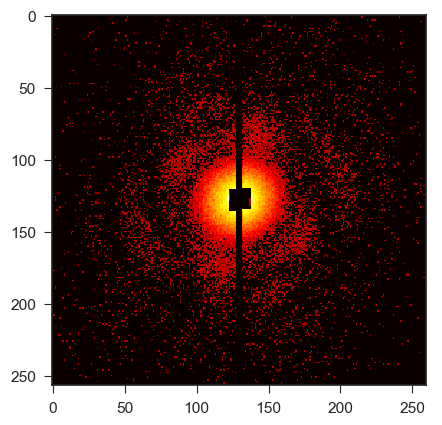

(257, 260)
done


In [47]:
image1 = convert(Array{Float64},photonConverter["pnccdBack"]["photonCount"][:,:,3])
imshow(image1.^(0.25), cmap="hot")
println(Base.size(image1))
println("done")

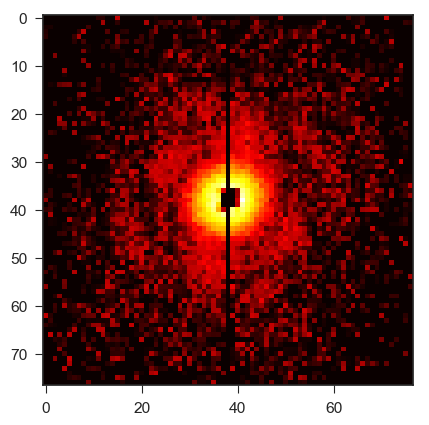

PyObject <matplotlib.image.AxesImage object at 0x133cb3c90>

In [48]:
#Experiment what happens if we Gauss-filter the images before resizing...no significant change happens
img = image1
sz = 2*38+1
σ = [0.1*Base.size(img)[1]/sz, 0.1*Base.size(img)[2]/sz]
kern = KernelFactors.gaussian(σ)   # from ImageFiltering
imgr = imresize(imfilter(img, kern, NA()), sz, sz).^0.25
imshow(imgr, cmap="hot")

### Sample single photons from the images

In [60]:
creload("ThreePhotons")

INFO: Reloading ThreePhotons


"ThreePhotons"

In [61]:
image_width = 38.0

38.0

In [62]:
image_volume = ImageVolume(img, image_width)
println("done")

done


In [73]:
incident_photons = 10000000
points,_ = pointsPerOrientation(image_volume,image_width, image_width/2.0, incident_photons; rot=eye(3), lambda=0.0, print_warning=false)
println("Generated $(length(points)) points, accepted $(length(points)/incident_photons*100.0)%.")

Overflow percentage: 0.0036699999999999997%
Generated 100142 points, accepted 1.00142%.


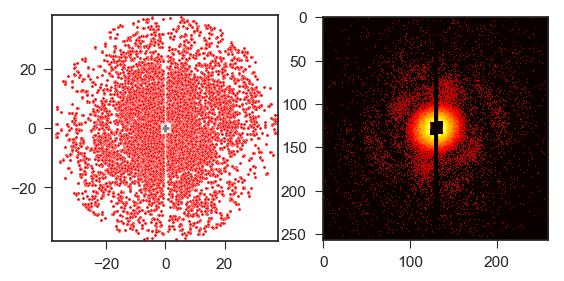

PyObject <matplotlib.image.AxesImage object at 0x16f33ec10>

In [74]:
subplot(1,2,1)
scatter([0.0], [0.0], marker="+", alpha=1.0, s=30.0, color="grey")
xlim(-image_width, image_width)
ylim(-image_width, image_width)
gca()[:set_aspect]("equal", adjustable="box")
#Plot scattering photons
scatter( [points[i][2] for i=1:length(points)], [-points[i][1] for i=1:length(points)], c="red", s=5.0, alpha=1.0, edgecolors="white")#

subplot(1,2,2)
imshow(img.^(0.25), cmap="hot")

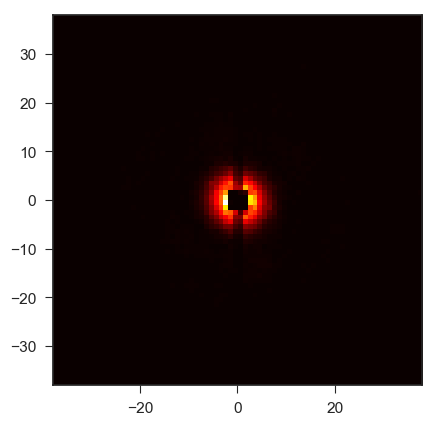

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-38.0, -37.0, -36.0, -35.0, -34.0, -33.0, -32.0, -31.0, -30.0, -29.0  …  29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0], [-38.0, -37.0, -36.0, -35.0, -34.0, -33.0, -32.0, -31.0, -30.0, -29.0  …  29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0], PyObject <matplotlib.image.AxesImage object at 0x18dc75990>)

In [104]:
gca()[:set_aspect]("equal", adjustable="box")
a,b,c,d = hist2D([points[i][2] for i=1:length(points)], [points[i][1] for i=1:length(points)], 2*38, [[-38, 38], [-38, 38]], cmap="hot")

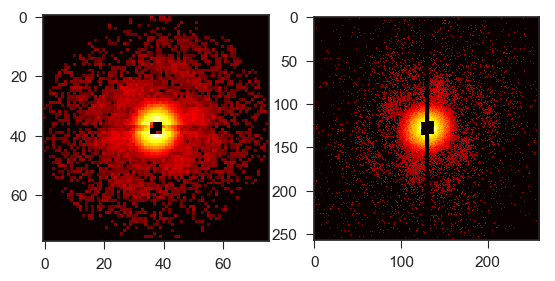

PyObject <matplotlib.image.AxesImage object at 0x193267250>

In [105]:
subplot(1,2,1)
imshow(rot180(a).^0.25, cmap="hot")
subplot(1,2,2)
imshow(img.^0.25, cmap="hot")

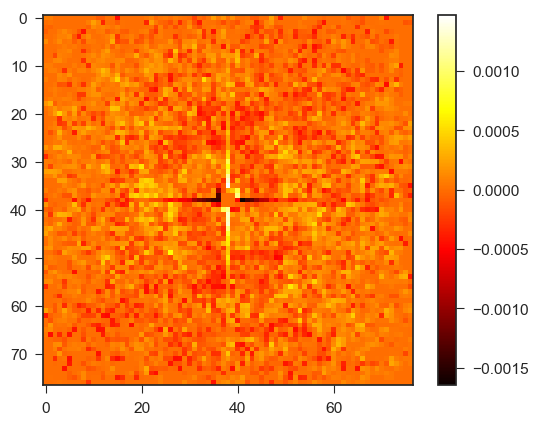

0.737443661702343

In [176]:
imshow(a/sum(abs,a)-imgr/sum(abs,imgr), cmap="hot")
colorbar()
sum(abs, a/sum(abs,a)-imgr/sum(abs,imgr))

## Inspecting histograms

In [24]:
creload("ThreePhotons")

INFO: Reloading ThreePhotons


"ThreePhotons"

In [47]:
# c2_coliphage_with_beamstop_sym,_,c3_coliphage_with_beamstop_sym,_,c1_coliphage_with_beamstop_sym = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_K2_40_K3_30_N32_processed/histo.dat")
# c2_coliphage_2e5,_,c3_coliphage_2e5,_,c1_coliphage_2e5 = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_2e5_processed_notsmoothed/histo.dat")
c2_coliphage_2e5_nobsc,_,c3_coliphage_2e5_nobsc,_,c1_coliphage_2e5_nobsc = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed/histo.dat")
c2_coliphage_2e5_nobsc_old,_,c3_coliphage_2e5_nobsc_old,_,c1_coliphage_2e5_nobsc_old = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed_old/histo.dat")
c2_coliphage_2e5_nobsc_sym,_,c3_coliphage_2e5_nobsc_sym,_,c1_coliphage_2e5_nobsc_sym = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed_symmetrized/histo.dat")

# c2_coliphage_4e5,_,c3_coliphage_4e5,_,_ = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_4e5_processed_notsmoothed/histo.dat")
# c2_coliphage_4e5_nobsc,_,c3_coliphage_4e5_nobsc,_,_ = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_4e5_nobsc_processed_notsmoothed/histo.dat")

# c2_coliphage_1_2e5_nobsc,_,c3_coliphage_1_2e5_nobsc,_,c1_coliphage_1_2e5_nobsc = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_1_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed/histo.dat")
# c2_coliphage_2_2e5_nobsc,_,c3_coliphage_2_2e5_nobsc,_,c1_coliphage_2_2e5_nobsc = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_2_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed/histo.dat")

# c2_coliphage_total_2e5_nobsc,_,c3_coliphage_total_2e5_nobsc,_,c1_coliphage_total_2e5_nobsc = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_total_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed/histo.dat")


println("Done")

Read from /Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed/histo.dat.
Loaded 4.308910896999991e9 doublets and 2.095133294548e12 triplets from /Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed/histo.dat generated from 4279 pictures.
Read from /Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed_old/histo.dat.
Loaded 1.241616301300001e10 doublets and 6.094670668888e12 triplets from /Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_photons_K2_40_K3_30_N32_2e5_nobsc_processed_notsmoothed_old/histo.dat generated from 12202 pictures.
Read from /Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_single_

Interact.Options{:SelectionSlider,Any}(162: "input-70" = 20 Any , "k1", 20, "20", 20, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(18, "18"),Pair{Any,Any}(30, "30"),Pair{Any,Any}(33, "33"),Pair{Any,Any}(32, "32"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(40, "40"),Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(21, "21"),Pair{Any,Any}(39, "39")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(164: "input-71" = 20 Any , "k2", 20, "20", 20, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(18, "18"),Pair{Any,Any}(30, "30"),Pair{Any,Any}(33, "33"),Pair{Any,Any}(32, "32"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(40, "40"),Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(21, "21"),Pair{Any,Any}(39, "39")…)), Any[], Any[], true, "horizontal")

Interact.Checkbox(166: "input-72" = true Bool , "normalization", true)

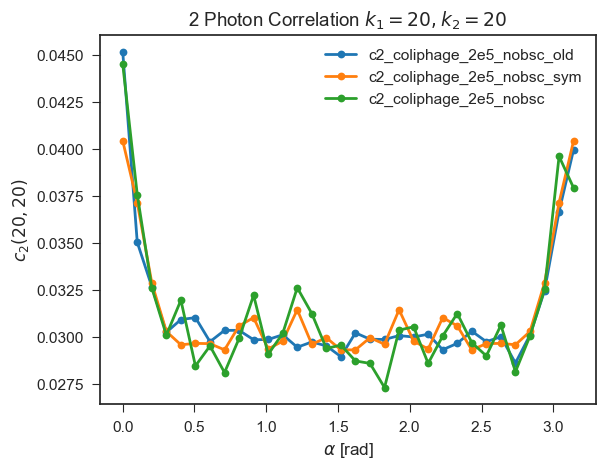

In [67]:
plot_random_2photon_slices(Dict(
#         "c2_coliphage_with_beamstop_sym"=>c2_coliphage_with_beamstop_sym,
#         "c2_coliphage_2e5"=>c2_coliphage_2e5,
#         "c2_coliphage_4e5"=>c2_coliphage_4e5,
        "c2_coliphage_2e5_nobsc"=>c2_coliphage_2e5_nobsc,
        "c2_coliphage_2e5_nobsc_old"=>c2_coliphage_2e5_nobsc_old,
        "c2_coliphage_2e5_nobsc_sym"=>c2_coliphage_2e5_nobsc_sym
#         "c2_coliphage_1_2e5_nobsc"=>c2_coliphage_1_2e5_nobsc,
#         "c2_coliphage_2_2e5_nobsc"=>c2_coliphage_2_2e5_nobsc,
#         "c2_coliphage_total_2e5_nobsc"=>c2_coliphage_total_2e5_nobsc
#         "c2_coliphage_4e5_nobsc"=>c2_coliphage_4e5_nobsc
        ))

In [50]:
#detector edges = 11.6 nm
#photon energy 1.6 keV = 7.5 Angstrom
L,LMAX,N,K3,K2,qm,lambda = 10,25,32,20,38,2*pi/90.0,7.5

(10, 25, 32, 20, 38, 0.06981317007977318, 7.5)

In [51]:
c2_reference = c2_coliphage_2e5_nobsc_sym
""

""

In [52]:
for L in [8,10,12,14]
    for low_K in 4:2:6
        for K2 in 28:4:36
            K_range=low_K:K2
            if L >= length(K_range)/2
                continue
            end
            intensity_coliphage_beamstop = retrieveSolution(c2_reference,Integer(L),LMAX, K_range, qm, lambda)
            c2_coliphage_beamstop_theo = twoPhotons(intensity_coliphage_beamstop, BasisType(N,L,LMAX,K3,lambda,qm/K2), K2, true, false)
            s = c2_difference(c2_reference, c2_coliphage_beamstop_theo, K_range)
            println("$L $(low_K) $K2 $(s)")
        end
    end
end
println("Done")

Extracting solution over K2_range=4:28 with K2=25 and L=8 and qmax=0.06981317007977318.
8 4 28 0.07455632489958182
Extracting solution over K2_range=4:32 with K2=29 and L=8 and qmax=0.06981317007977318.
8 4 32 0.09888920649896579
Extracting solution over K2_range=4:36 with K2=33 and L=8 and qmax=0.06981317007977318.
8 4 36 0.12519345937486964
Extracting solution over K2_range=6:28 with K2=23 and L=8 and qmax=0.06981317007977318.
8 6 28 0.08563012793766141
Extracting solution over K2_range=6:32 with K2=27 and L=8 and qmax=0.06981317007977318.
8 6 32 0.09131705676282559
Extracting solution over K2_range=6:36 with K2=31 and L=8 and qmax=0.06981317007977318.
8 6 36 0.11434921222188431
Extracting solution over K2_range=4:28 with K2=25 and L=10 and qmax=0.06981317007977318.
10 4 28 0.07788964733404603
Extracting solution over K2_range=4:32 with K2=29 and L=10 and qmax=0.06981317007977318.
10 4 32 0.10398259680270262
Extracting solution over K2_range=4:36 with K2=33 and L=10 and qmax=0.069813

In [53]:
L = 12
K_range = 4:32
K2 = maximum(K_range)
intensity_coliphage_beamstop = retrieveSolution(c2_reference, Integer(L),LMAX, K_range, qm, lambda)
c2_coliphage_beamstop_theo = twoPhotons(intensity_coliphage_beamstop, BasisType(N,L,LMAX,K3,lambda,qm/K2), K2, true, false)
c2_difference(c2_reference, c2_coliphage_beamstop_theo, K_range)

Extracting solution over K2_range=4:32 with K2=29 and L=12 and qmax=0.06981317007977318.


0.09994037883523678

Interact.Options{:SelectionSlider,Any}(155: "input-67" = 20 Any , "k1", 20, "20", 20, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(18, "18"),Pair{Any,Any}(30, "30"),Pair{Any,Any}(33, "33"),Pair{Any,Any}(32, "32"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(40, "40"),Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(21, "21"),Pair{Any,Any}(39, "39")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(157: "input-68" = 20 Any , "k2", 20, "20", 20, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(18, "18"),Pair{Any,Any}(30, "30"),Pair{Any,Any}(33, "33"),Pair{Any,Any}(32, "32"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(40, "40"),Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(21, "21"),Pair{Any,Any}(39, "39")…)), Any[], Any[], true, "horizontal")

Interact.Checkbox(159: "input-69" = true Bool , "normalization", true)

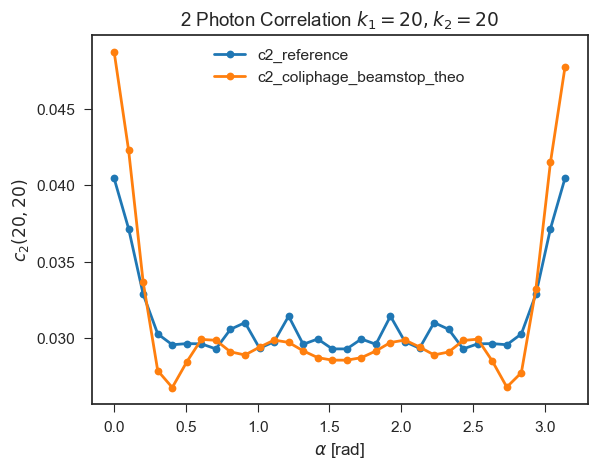

In [66]:
plot_random_2photon_slices(Dict(
#         "c2_coliphage_with_beamstop_sym"=>c2_coliphage_with_beamstop_sym,
        "c2_reference"=>c2_reference,
        "c2_coliphage_beamstop_theo"=>c2_coliphage_beamstop_theo,
        ))

In [74]:
basis = calculate_basis(L,LMAX,N,K3,lambda,qm/K2)
println("Done")

Calculating complex basis with N=32 L=10 K=20 (LMAX=25, lambda=7.5, dq=0.0018371886863098206).
Calculation complete (11841 basislen).
Done


In [82]:
average_intensity = deserializeFromFile("/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_determination_single_triplets_2e5_nobsc_K2_4_36_K3_4_30_L10/1000/state.dat")["intensity"]
println("Loaded")

Loaded


In [83]:
#FullCorrelation_parallized(intensity::SphericalHarmonicsVolume, basis::BasisType, minimal::Bool=true, normalize::Bool=false, return_raw::Bool=false)
c3_theo = FullCorrelation_parallized(average_intensity, basis)
println("done")

done


Interact.Options{:SelectionSlider,Any}(86: "input-38" = 10 Any , "k1", 10, "10", 10, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(18, "18"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(7, "7"),Pair{Any,Any}(9, "9"),Pair{Any,Any}(10, "10"),Pair{Any,Any}(19, "19"),Pair{Any,Any}(17, "17"),Pair{Any,Any}(8, "8")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(88: "input-39" = 10 Any , "k2", 10, "10", 10, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(18, "18"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(7, "7"),Pair{Any,Any}(9, "9"),Pair{Any,Any}(10, "10"),Pair{Any,Any}(19, "19"),Pair{Any,Any}(17, "17"),Pair{Any,Any}(8, "8")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(90: "input-40" = 10 Any , "k3", 10, "10", 10, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(18, "18"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(7, "7"),Pair{Any,Any}(9, "9"),Pair{Any,Any}(10, "10"),Pair{Any,Any}(19, "19"),Pair{Any,Any}(17, "17"),Pair{Any,Any}(8, "8")…)), Any[], Any[], true, "horizontal")

Interact.Checkbox(92: "input-41" = true Bool , "normalization", true)

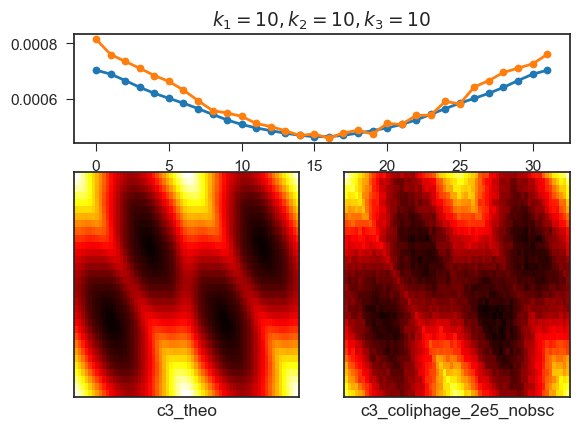

In [84]:
plot_random_3photon_slices(Dict(
        "c3_theo"=>c3_theo,
#         "c3_coliphage_with_beamstop_sym"=>c3_coliphage_with_beamstop_sym,
#         "c3_coliphage_2e5" => c3_coliphage_2e5,
        "c3_coliphage_2e5_nobsc" => c3_coliphage_2e5_nobsc
        ), 0.0)

### Completing the Core

In [96]:
#Preparation of environment
using ThreePhotons
include("paper.jl")
#For Development:
using ClobberingReload
using ProgressMeter
using HDF5
using PyPlot
using Images
using Interact
# creload(ThreePhotons)
data_dir = "/Users/ben/Documents/biophysics/projects/reconstruction/data"

"/Users/ben/Documents/biophysics/projects/reconstruction/data"

In [525]:
c2_coliphage_with_beamstop_sym,_,c3_coliphage_with_beamstop_sym,_,c1_coliphage_with_beamstop_sym = loadHistograms(1,1,"/Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_K2_40_K3_30_N32_processed/histo.dat")
println("Done")

Loaded NaN doublets and NaN triplets from /Users/ben/Documents/biophysics/projects/reconstruction/data/output_owl/exp_data/coliphage_K2_40_K3_30_N32_processed/histo.dat generated from 14368 pictures.
Done


In [545]:
creload("ThreePhotons")

INFO: Reloading ThreePhotons


"ThreePhotons"

Saving cube to intensity_averaged.mrc with cubesize=77
shfit = -10.300393261427415
Saving cube to intensity_averaged_corrected.mrc with cubesize=77


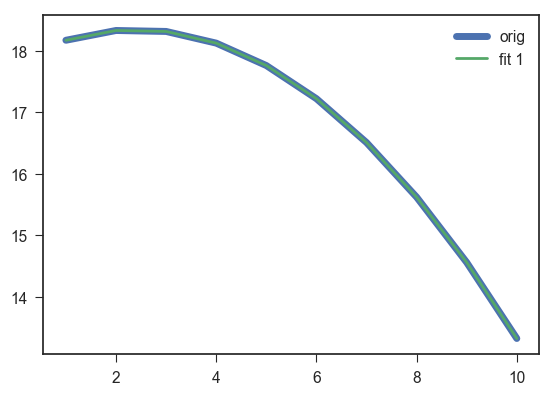

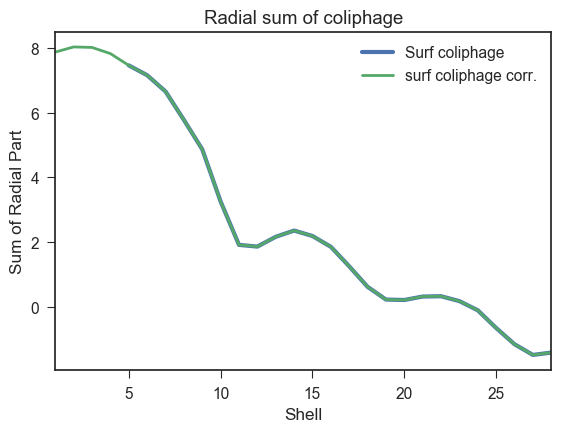

done


In [546]:
extended_corrected_intensity = complete_core("../../../data/output_owl/exp_data/coliphage_determination_rerun_K2_5_38_K3_5_28_L12_fitted", c1_coliphage_with_beamstop_sym, 1:4, 5:28, plotting=true)
# averaged_density = phase_completed_intensity(extended_corrected_intensity, "coliphage_determination_paper_lowrange_2_fitted", 8)
println("done")

## Phase completed intensity

In [2]:
#Best so far
# averaged_density = loadCube("../../../data/output_owl/exp_data/coliphage_determination_paper_K2_10_36_K3_10_26_L10_fitted_phased_center_1_9_fit_3_10/b0.99/density_averaged.mrc")

# averaged_density = loadCube("../../../data/output_owl/exp_data/coliphage_determination_single_triplets_K2_10_32_K3_10_30_L10_fitted_phased_center_1_9/b0.8/density_averaged.mrc")
averaged_density = loadCube("../../../data/output_owl/exp_data/coliphage_determination_single_triplets_2e5_nobsc_K2_4_36_K3_4_30_L10_fitted_phased_center_1_3/b0.8/density_averaged.mrc")

# averaged_density = loadCube("../../../data/output_owl/exp_data/coliphage_determination_single_triplets_2e5_nobsc_sym_K2_4_32_K3_4_30_L12_fitted_phased_center_1_3/b0.9/density_averaged.mrc")

#exp_data/coliphage_determination_paper_K2_10_36_K3_10_26_fitted_phased_center_1_9_fit_3_10/b0.99/density_averaged.mrc
println("Done")

Done


In [3]:
dr(averaged_density)

90.0

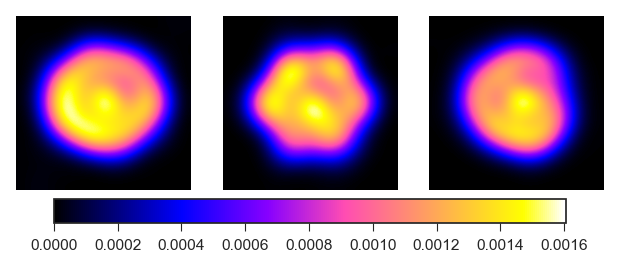

In [30]:
plot_slice = function(data::Matrix{Float64})
    fig = imshow(data, cmap="gnuplot2", interpolation="bicubic")
    fig[:axes][:get_xaxis]()[:set_visible](false)
    fig[:axes][:get_yaxis]()[:set_visible](false)
    axis("off")
end
fig = figure()
center = ceil(Int64, Base.size(averaged_density.cube)[1]/2.0)
width = 8
subplot(1,3,1)
plot_slice(real(averaged_density.cube[center-width:center+width, center ,center-width:center+width]))
subplot(1,3,2)
plot_slice(real(averaged_density.cube[center, center-width:center+width ,center-width:center+width]))
subplot(1,3,3)
plot_slice(real(averaged_density.cube[center-width:center+width ,center-width:center+width, center]))

cbar_ax = fig[:add_axes]([0.1, 0.25, 0.8, 0.05])
# fig.colorbar(im, cax=cbar_ax)
colorbar(orientation="horizontal", cax = cbar_ax)
tight_layout()
savefig("paper/coliphage_slices.pdf", bbox_inches="tight")

In [18]:
include("paper.jl")
creload(ThreePhotons)

INFO: Reloading ThreePhotons


"ThreePhotons"

In [3]:
kcut = 20
density1 = loadCube("../../../data/output_owl/exp_data/coliphage_determination_single_triplets_2e5_nobsc_sym_K2_4_32_K3_4_30_L12_fitted_phased_center_1_3/b0.9/density_averaged.mrc")
density2 = loadCube("../../../data/output_owl/exp_data/coliphage_determination_single_triplets_2e5_nobsc_sym_K2_4_32_K3_4_30_L14_fitted_phased_center_1_3/b0.85/density_averaged.mrc")
density2,a,b,c = fitStructures_random(density2, density1, 1:kcut, 24, 0.995, nworkers())
println("Done")

Best intensity correlation: 0.9864343442797985
Done


In [5]:
saveCube(density1, "density1.mrc")
saveCube(density2, "density2.mrc")

Saving cube to density1.mrc with cubesize=85
Saving cube to density2.mrc with cubesize=85


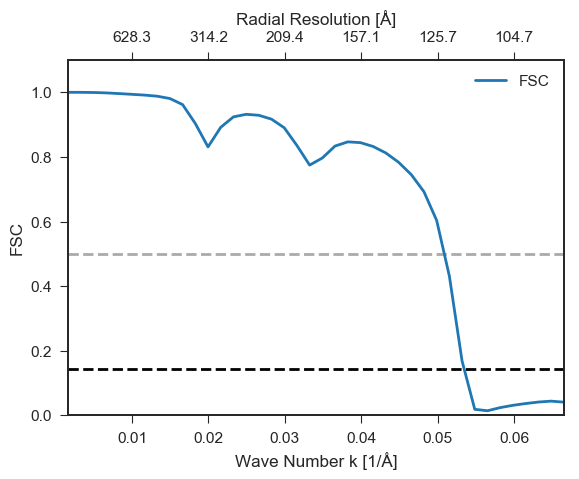

Resolution = 117.50442994127738


In [23]:
# For starters, look at Fourier Shell Correlation between two runs
function plot_coliphage_fsc(kcut::Int64)
    figure(figsize=(6,5))
    fig, ax = subplots(figsize=(6,5))
    
    density1 = loadCube("density1.mrc")
    density2 = loadCube("density2.mrc")

    qm = 2*pi/90.0#qmax(density1)
#     println(qm)
#     println(2*pi/90.0)
    dq = 2*qm/(density1.cubesize-1)
    
    plot(get_qrange(kcut, dq),0.5*ones(kcut),"g--", linewidth=2.0, color="#AAAAAA")
    plot(get_qrange(kcut, dq),0.143*ones(kcut),"g--", linewidth=2.0, color="#000000")
    
    fsc = shell_correlation(forward(density1), forward(density2), kcut, cor_FSC)
    plot_sc(fsc, zeros(kcut), kcut, dq, linestyle="-",
    label="FSC", color="C0",
    ytext="FSC", upper_y_limit=1.1)
    legend()
#     res_mean = Dict(dir=>sc_vs_triplets[dir]["res"] for dir in dirs)

#     for dir in dirs
#         plot_sc(sc_vs_triplets[dir]["fsc"],sc_vs_triplets[dir]["fsc_err"], kcut, dq,linestyle=sc_vs_triplets[dir]["linestyle"], label=@sprintf("%s (%.1f Å)", sc_vs_triplets[dir]["label"], res_mean[dir]), color=sc_vs_triplets[dir]["color"], ytext="FSC")
#     end
    add_resolution_axis( kcut, dq)

#     if plot_inset
#         plot_resolution_inset(sc_vs_triplets, fig, ax, dirs, dq, kcut)
#     end

    tight_layout()
    savefig("paper/coliphage_FSC.pdf", bbox_inches="tight")
    
    println("Resolution = $(calculate_maximum_resolution(fsc, dq, 0.143))")
end
plot_coliphage_fsc(40)

# Resolution of Coliphage Reconstruction

In [113]:
density_1 = loadCube("../../../data/output_owl/exp_data/coliphage_determination_single_triplets_2e5_nobsc_K2_4_36_K3_4_30_L10_fitted_phased_center_1_3/b0.8/density_averaged.mrc")
density_2 = loadCube("../../../data/output_owl/exp_data/coliphage_determination_single_triplets_2e5_nobsc_K2_4_36_K3_4_30_L10_fitted_phased_center_1_3/b0.85/density_averaged.mrc")
println("done")

done


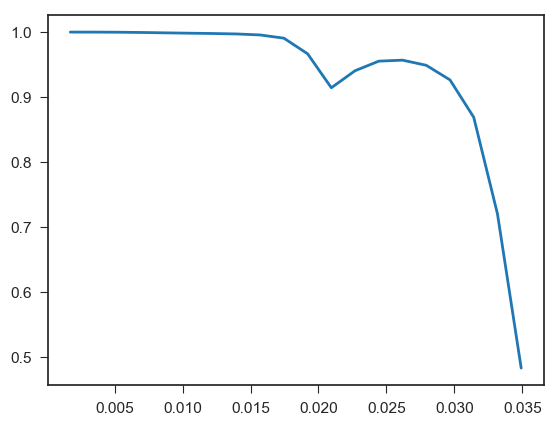

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12fdc6490>

In [120]:
K_res_range = 1:K3
fsc = shell_correlation_FSC(forward(center_cube(density_1)), forward(center_cube(density_2)), maximum(K_res_range))
coliphage_dq = qm / 40
plot(collect(K_res_range)*coliphage_dq,fsc)

# Investigating Multi Particle Events

In [ ]:
#Preparation of environment
using ThreePhotons
include("paper.jl")
include("plotting.jl")
#For Development:
using ClobberingReload
using ProgressMeter
# creload(ThreePhotons)
data_dir = "/Users/ben/Documents/biophysics/projects/reconstruction/data"

In [ ]:
L,LMAX,N,K3,K2,lambda = 18,25,32,20,38,4.0

In [ ]:
density_K38,fourier_K38,intensity_K38 = createSphericalHarmonicsStructure("/Users/ben/Documents/biophysics/projects/reconstruction/data/structures/crambin.pdb", 25, 38, float(38))
println("Done")

In [ ]:
c2_single_full,c2_single,_,c3_single = loadHistograms(K3,K3, "$(ENV["DETERMINATION_DATA"])/output_owl/data_generation/SH_10p_N32_K38_R38.0_P3276800000/histo.dat", false)
c2_multi_full,c2_multi,_,c3_multi,c1_multi= loadHistograms(K3,K3, "$(ENV["DETERMINATION_DATA"])/output_owl/data_generation/multi_2_SH_10p_N32_K38_R38.0_P327680000/histo.dat", true)
println("Done loading")

In [ ]:
#Can I make them congruent? Is there a linear transformation that does that?
k1,k2 = 16,5
p = 0.99-2.0
# k1,k2 = 17,10
# p1,p2 = 1.9, 0.005
a = c2_single[:,k2,k1]
b = c2_multi[:,k2,k1]
mb = mean(b)
ma = mean(a)
# c = 1.0*a + 0.99*ma#(b - (0.99*mb))# mb*p
c = a + ma
plot(a/sumabs(a), "o-", color="blue",label="single")
plot(b/sumabs(b), "o-", color="green",label="multi")
plot(c/sumabs(c), "o-", color="orange",label="single rec.")
legend()
# plot([mean(a) for i=1:32], "o-", color="blue")
# plot([mean(b) for i=1:32], "o-", color="green")

In [ ]:
creload("ThreePhotons")

In [ ]:
c1_multi_theo = [real( 1.0/sqrt(16.0*pi^3)*getc(intensity_K38,k,0,0) ) for k = 1:K2]
c2_single_theo = twoPhotons(intensity_K38, BasisType(N,L,LMAX,K3,0.0,dq(intensity_K38)), K2, true, false)
intensity_K38_multi = deepcopy(intensity_K38)
for k = 1:K2
    setc(intensity_K38_multi,k,0,0, getc(intensity_K38_multi,k,0,0) + c1_multi_theo[k])
end
c2_multi_theo = twoPhotons(intensity_K38_multi, BasisType(N,L,LMAX,K3,0.0,dq(intensity_K38_multi)), K2, true, false)
println("done")

In [ ]:
c1 = 1/(8*pi^2)*(pi/2.0)*0.5*c1_multi/sumabs(c1_multi)#/1.3
c2 = 1/(8*pi^2)*c2_multi_full/sumabs(c2_multi_full)#norm(reshape(c2_multi_full,N*K2^2))
c2_single = c2_single_full

# c1 = c1_multi_theo
# c2 = c2_multi_theo
# c2_single = c2_single_theo


c2_single_retrieved = copy(c2)
for k1=1:K2
    for k2=1:k1
        c2_single_retrieved[:,k2,k1] = c2[:,k2,k1] - ones(32)*c1[k1]*c1[k2]*3.0
    end
end

plot_single_2photon_slice(Dict( "single"=>c2_single/sumabs(c2_single),"single retrieved"=>c2_single_retrieved/sumabs(c2_single_retrieved)), 10, 5, figure(), false)
# plot_random_2photon_slices(Dict( "single"=>c2_single/sumabs(c2_single),"single retrieved"=>c2_single_retrieved/sumabs(c2_single_retrieved)))

In [ ]:
norm(c1_multi)

In [ ]:
sumabs(c1_multi)

In [ ]:
title("Radial sum of photons")
plot(c1_multi/sumabs(c1_multi), label="Surf single")
plot(c1_multi_theo/sumabs(c1_multi_theo), label="surf single theo")
ylabel("Sum of Radial Part")
xlabel("Shell")
legend()
yscale("log")

# Save intensity of coliphage data

In [ ]:
for i = 1000:1019
    dir = "$(ENV["DETERMINATION_DATA"])/output_owl/exp_data/coliphage_determination/$i"
    state = deserializeFromFile("$dir/state.dat")
    params = deserializeFromFile("$dir/params.dat")
    intensity = deleteTerms(state["intensity"],params["K"],params["L"])
    saveCube(intensity, "$dir/unfitted_intensity.mrc")
end

# Implement Ewald Sphere

In [ ]:
creload(ThreePhotons)

In [ ]:
# using ThreePhotons
# using PyPlot
# using ClobberingReload
# density_K38,fourier_K38,intensity_K38 = createSphericalHarmonicsStructure("/Users/ben/Documents/biophysics/projects/reconstruction/data/structures/crambin.pdb", 25, 38, float(38))
surf = getSurfaceVolume(intensity_K38)
println("done")

In [ ]:
points_raw = pointsPerOrientation(surf, intensity_K38.rmax, intensity_K38.rmax/3.0, 50000)[1]
points_raw_Ewald = [detector_to_Ewald_sphere(points_raw[i], 4.0) for i = 1:length(points_raw)]

points_2d = [points_raw[i][j] for i = 1:length(points_raw),j=1:2]
points_3d_Ewald = [points_raw_Ewald[i][j] for i = 1:length(points_raw_Ewald),j=1:3]
println("done")

In [ ]:
# scatter(points_2d[:,1], points_2d[:,2])
xlim(-2.0, 2.0)
ylim(-2.0, 2.0)
zlim(0.0, 2.0)
scatter3D(points_3d_Ewald[:,1], points_3d_Ewald[:,2], points_3d_Ewald[:,3])

In [ ]:
"""From an intensity cube, generates scattering data and plots it"""
#noise::Noise=GaussianNoise(0.0, 0.0, false)
function plot_scattering_image(intensity::CubeVolume, qmax::Float64, number_incident_photons::Integer; point_size::Float64=50.0, colorfill="red", coloredge="black")

    p,rot = pointsPerOrientation(intensity, qmax, qmax/3.0, number_incident_photons)

    #Plot underlying intensity
    r = linspace(-qmax, qmax, intensity.cubesize)
    myslice = Float64[getVolumeInterpolated(intensity, rot*detector_to_Ewald_sphere([-x,y,0.0])) for x=r,y=r]
    myslice = (myslice).^(0.2)
    # myslice = log(max(myslice, 1e-6))
    # myslice = log(myslice)
    fig = imshow(myslice, interpolation="hermite", extent=[-qmax, qmax, -qmax, qmax], cmap="Blues")

    #Plot scattering photons
    scatter( [p[i][2] for i=1:length(p)], [ p[i][1] for i=1:length(p)], c=colorfill, s=point_size, alpha=1.0, edgecolors=coloredge)#

    #plot center
    scatter([0.0], [0.0], marker="+", alpha=1.0, s=100.0, color="red")

    fig[:axes][:get_xaxis]()[:set_visible](false)
    fig[:axes][:get_yaxis]()[:set_visible](false)
end

In [ ]:
plot_scattering_image(intensityCube_K38, intensityCube_K38.rmax, 1000)

## Calculating correlations with Ewald sphere

In [ ]:
addprocs()

In [ ]:
creload(ThreePhotons)

In [ ]:
using ClobberingReload
using ThreePhotons
using PyPlot

In [ ]:
density_K38,fourier_K38,intensity_K38 = createSphericalHarmonicsStructure("/Users/ben/Documents/biophysics/projects/reconstruction/data/structures/crambin.pdb", 25, 38, float(38))
surf = getSurfaceVolume(intensity_K38)
println("Done")

In [ ]:
#function calculate_basis(L::Int64, LMAX::Int64, N::Int64, K::Int64, lambda::Float64, dq::Float64, forIntensity=true)
LMAX=25
# L,N,K = 18,32,26
L,N,K = 4,4,4
lambda=0.0
dq=0.0
@time basis = calculate_basis(L, LMAX, N, K, lambda, dq)
println("Done")

In [ ]:
CUDA_init()
d_basis = CUDA_store_basis(basis, L, LMAX, N, K, lambda, dq)
println("Done")

In [ ]:
a = FullCorrelation_parallized(intensity_K38, d_basis, true, false, true)

In [ ]:
FullC3(intensity_K38, L, K, N, LMAX)

# Investigating Ewald Sphere datasets

In [ ]:
addprocs()

In [1]:
#Preparation of environment
using ThreePhotons
using ClobberingReload
include("paper.jl")
data_dir = "/Users/ben/Documents/biophysics/projects/reconstruction/data"
println("done")


done


In [ ]:
c2_ewald0_full,c2_ewald0,_,c3_ewald0 = loadHistograms(16, 16, "$(ENV["DETERMINATION_DATA"])/output_owl/data_generation/SH_10p_N32_K38_R38.0_P3276800000/histo.dat", false)
c2_ewald25_full,c2_ewald25,_,c3_ewald25,_ = loadHistograms(16, 16, "$(ENV["DETERMINATION_DATA"])/output_owl/data_generation/Ewald_large_SH_10p_N32_K2_38_K3_26_R38.0_P3276800000_lambda_2.5/histo.dat", true)
println("done")

In [257]:
L,LMAX,N,K3,K2,rmax,lambda,mdq = 18,25,32,26,38,38.0,0.0,dq(intensity_K38)

(18,25,32,26,38,38.0,0.0,0.08267349088394192)

In [4]:
density_K38,fourier_K38,intensity_K38 = createSphericalHarmonicsStructure("/Users/ben/Documents/biophysics/projects/reconstruction/data/structures/crambin.pdb", LMAX, K2, float(K2))
println("done")

Initializing SH structure from /Users/ben/Documents/biophysics/projects/reconstruction/data/structures/crambin.pdb with LMAX=25, KMAX=38, rmax=38.0.
done


In [7]:
# basis = calculate_basis(L,LMAX,N,K3,lambda,dq(intensity_K38))
println("Done")

Done


In [153]:
creload("ThreePhotons")

INFO: Reloading ThreePhotons


"ThreePhotons"

In [24]:
#Tried nonlinear optimization for inversion of two-photon correlation
#Didn't work because expressions are too complex for @NLobjective
# using JuMP
# using Ipopt

# function scalar(A::Array{JuMP.Variable,2}, k1::Int64, k2::Int64, l::Int64, LMAX::Int64)
#     vec1 = A[k1,:]
#     vec2 = A[k2,:]
#     return sum(vec1[seanindex(l,m,LMAX)]*conj(vec2[seanindex(l,m,LMAX)]) for m=-l:l)
# end

# function kernel(A::Array{JuMP.Variable,2}, k1::Int64, k2::Int64, N::Int64, L::Int64, LMAX::Int64)
#     return c2_ewald25_full[:,k2,k1] - 
#             [(1/(4*pi))*Plm(l,0,alpha_star(alpha, k1, k2, mdq, lambda)) for alpha = alpharange(N), l = 0:2:L]*
#             [scalar(A, k1, k2, l, LMAX) for l=0:2:L]
# end

# K2=18
# L=8
# m = Model(solver=IpoptSolver())
# mdq = dq(intensity_K38)
# @variable(m, -1e16 <= A[1:K2,1:num_coeff(LMAX)] <= 1e16)
# # @constraint(m, -1e16 <= A[:,:] <= 1e16)
# # @constraint(m, sum(A) <= 1e16)
# @objective(m, :Min, sum( sum(kernel(A, k1, k2, N, L, LMAX)) for k1=1:K2, k2=1:k1))
# # function infocallback(cb)
# #     node      = MathProgBase.cbgetexplorednodes(cb)
# #     obj       = MathProgBase.cbgetobj(cb)
# #     bestbound = MathProgBase.cbgetbestbound(cb)
# #     println(bestbound)
# # end
# # addinfocallback(m, infocallback, when = :Intermediate)
# status = solve(m)


:Max

In [453]:
function retrieveSolution_mod(c2::C2, L::Int64, LMAX::Int64, K2_range::UnitRange{Int64}, qmax::Float64, lambda::Float64)
    N,_,_ = size(c2)
    K2 = length(K2_range)
    K2_high = maximum(K2_range)
    K2_low = minimum(K2_range)
    @assert L < K2/2 #2*L+1 = K2

    #Create empty Spherical Harmonics volume
    intensity = SphericalHarmonicsVolume(LMAX, K2_high, qmax)
    println("Extracting solution over K2_range=$(K2_range) with K2=$(K2) and L=$L and qmax=$qmax.")
    mdq = dq(intensity)
    eigenvecs = Dict()
    eigenvals = Dict()
    Gmatrices = Dict()

    for l = 0:2:L
        G = zeros(Float64, K2, K2)
        for k1 in K2_range
            for k2 = K2_low:k1
                slice = c2[:,k2,k1]

                #symmetrize 2 photon correlation if lambda = 0.0
                if lambda == 0.0
                    slice = 0.5*(slice + reverse(slice))
                end
                upperL = min(L, min(k1,k2)*2-2)
                A = Float64[ (1/(4*pi))*Plm(l,0,alpha_star(alpha, k1, k2, mdq, lambda)) for alpha = alpharange(N), l = 0:2:upperL]
                #This inversion is stable
                fac = A \ slice
#                 println("$l $k1 $k2")
                if l <= upperL
                    val = fac[round(Int64,l/2)+1]
                    G[k2-K2_low+1,k1-K2_low+1] = val
                    G[k1-K2_low+1,k2-K2_low+1] = val
                end
            end
        end
        #Diagonalize the matrix
        F = eigfact(Symmetric(G),K2-(2*l+1)+1:K2)
        # F = eigfact(G, permute=true, scale=false)

        eigenval, eigenvectors = F[:values], F[:vectors]

        #Calculate the vectors
        eigenvalmatrix = diagm(sqrt(max(0.0, eigenval)))
        eigenvecs[l] = eigenvectors'
        eigenvals[l] = eigenvalmatrix
        Gmatrices[l] = G
        m = eigenvalmatrix*eigenvectors'

        for k in K2_range
            cvec_set(intensity,k,l,(m[:,k-K2_low+1]))
            # vec = m[K2-(2*l):K2,k]
            # cvec_set(intensity,k,l, vec)
        end
    end

    intensity = real_to_comp(intensity)

    if negativityCheck(intensity) > 0.33
        for k = 1:intensity.KMAX intensity.coeff[k] *= -1.0 end
    end

    return intensity,eigenvecs,eigenvals,Gmatrices
end

retrieveSolution_mod (generic function with 1 method)

In [454]:
lambda = 2.5
c2_theo_lambda = twoPhotons(intensity_K38, BasisType(N,L,LMAX,K3,lambda,dq(intensity_K38)), K2, true, false)
# c2ref = c2_theo_lambda
c2ref = c2_ewald25_full#add_Gaussian_filter(c2_ewald25_full,0.5)

intensity_lambda,eigenvecs,eigenvals,Gmatrices = retrieveSolution_mod(c2ref, L, LMAX, 1:K2, qmax(K2, float(rmax)), lambda)
# intensity_lambda = retrieveSolution(c2_theo_lambda, L, LMAX, 1:K2, qmax(K2, float(rmax)), lambda)

c2_theo_lambda_exp = twoPhotons(intensity_lambda, BasisType(N,L,LMAX,K3,lambda,dq(intensity_lambda)), K2, true, false)

# saveCube(deleteTerms(intensity_lambda,K3,L), "test_lambda_$(lambda).mrc")
# saveCube(intensity_lambda, "test_lambda_$(lambda)_nocut.mrc")

# checkRotationSearch(deleteTerms(intensity_lambda, K3, L), intensity_K38, 1:K3, L, BasisType(N,L,LMAX,K3,lambda,dq(intensity_K38)); iterations=1.4e4, reduce_stepsize=1000, plotting=false, include_negativity=false, energy=(x)->0.0, save_structures=true)
c2_difference(c2_ewald25_full, c2_theo_lambda_exp, 1:K2)

Extracting solution over K2_range=1:38 with K2=38 and L=18 and qmax=3.141592653589793.


0.2769004036086113

In [455]:
G_alt = [real(Base.dot( cvec_get(intensity_K38, k1, l), cvec_get(intensity_K38, k2, l))) for k1=1:K2, k2=1:K2]

38×38 Array{Float64,2}:
  8.67751e-18   9.51078e-14  …      3.67208e-8       2.20451e-8 
  9.51078e-14   4.3926e-9           0.000200019      0.000430601
  4.13858e-11   1.90691e-6          0.0984732        0.193741   
  2.28996e-9    0.000105052         6.43727         11.2457     
  3.71879e-8    0.00169225        128.695          194.656      
  2.52888e-7    0.0113269    …   1124.73          1437.17       
  8.49217e-7    0.0367425        5107.69          5359.62       
  1.49984e-6    0.0592591       13023.9          10812.3        
  1.41283e-6    0.040269        18739.3          11825.7        
  9.24209e-7    0.00300223      13763.8           7375.02       
  1.07614e-6    0.0105434    …   3061.64          5412.97       
  1.06871e-6    0.0299823       -1071.6           5099.6        
 -6.57903e-8    0.00160432         70.8749        -996.501      
  ⋮                          ⋱                                  
  7.90735e-8    0.00254503       -900.464         -109.854      
 

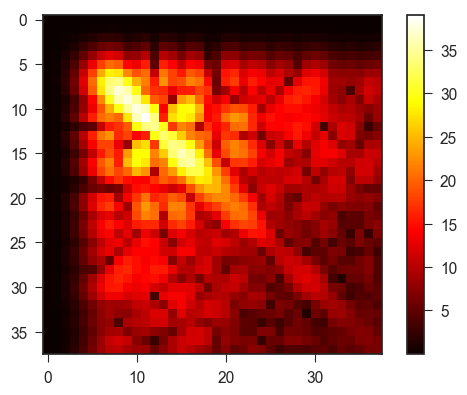

PyObject <matplotlib.colorbar.Colorbar object at 0x350494410>

In [456]:
imshow(abs(G_alt).^0.25, cmap="hot")
colorbar()

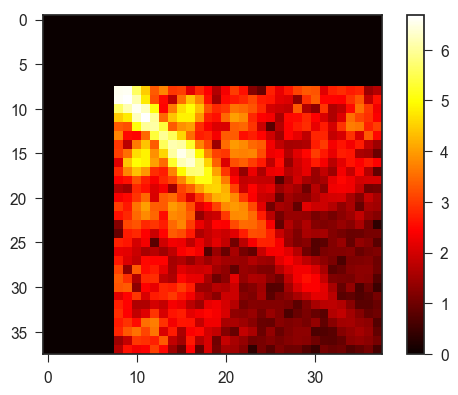

PyObject <matplotlib.colorbar.Colorbar object at 0x353307b50>

In [457]:
imshow(abs(Gmatrices[l]).^0.25, cmap="hot")
colorbar()

In [458]:
l = 16
res = eigfact((Gmatrices[l]))
eigenval, eigenvectors = res[:values], res[:vectors]
eigenvalmatrix = diagm(sqrt(complex(eigenval)))
F = (eigenvalmatrix*eigenvectors')'

38×38 Array{Complex{Float64},2}:
 0.0-0.0im        0.0-0.0im       …         0.0-0.0im        0.0-0.0im
 0.0-0.0im        0.0-0.0im                 0.0-0.0im        0.0-0.0im
 0.0-0.0im        0.0-0.0im                 0.0-0.0im        0.0-0.0im
 0.0-0.0im        0.0-0.0im                 0.0-0.0im        0.0-0.0im
 0.0-0.0im        0.0-0.0im                 0.0-0.0im        0.0-0.0im
 0.0-0.0im        0.0-0.0im       …         0.0-0.0im        0.0-0.0im
 0.0-0.0im        0.0-0.0im                 0.0-0.0im        0.0-0.0im
 0.0-0.0im        0.0-0.0im                 0.0-0.0im        0.0-0.0im
 0.0-5.42958im    0.0+4.87217im         25.7066-0.0im    24.2465-0.0im
 0.0+6.99915im    0.0-4.76809im         25.4404-0.0im    31.0075-0.0im
 0.0-5.03712im    0.0-1.10207im   …     14.7406-0.0im    37.5309-0.0im
 0.0+5.19124im    0.0+3.00583im         5.38194-0.0im    33.0639-0.0im
 0.0-5.05818im    0.0-3.75793im         6.23286-0.0im    15.4852-0.0im
    ⋮                             ⋱         

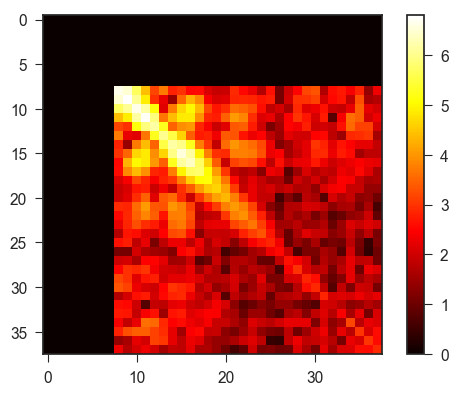

PyObject <matplotlib.colorbar.Colorbar object at 0x3537da250>

In [459]:
imshow(abs(F*F').^(0.25), cmap="hot")
colorbar()

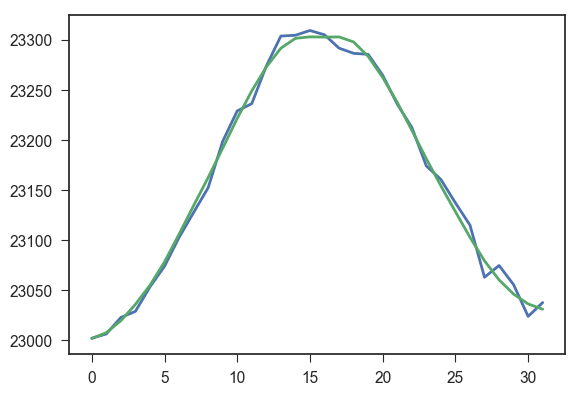

214.91446807554166


10-element Array{Float64,1}:
     3.00307e5
 39340.9      
 64898.1      
 70226.8      
 61171.2      
 44257.2      
 26205.5      
 12557.7      
  4381.81     
   956.21     

In [460]:
k1 = 36
k2 = 2
slice = c2ref[:,k2,k1]
A = Float64[ (1/(4*pi))*Plm(l,0,alpha_star(alpha, k1, k2, mdq, lambda)) for alpha = alpharange(N), l = 0:2:L]
fac = A \ slice
plot(slice, label="Slice")
plot(A*fac)
println(sumabs(A*fac-slice))
fac

In [429]:
orig = c2_ewald25_full
fitted = c2_theo_lambda_exp
theo = c2_theo_lambda
println("done")

done


Interact.Options{:SelectionSlider,Any}(113: "input-49" = 19 Any ,"k1",19,"19",19,Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict{Any,Any}(Pair{Any,Any}(18,"18"),Pair{Any,Any}(30,"30"),Pair{Any,Any}(33,"33"),Pair{Any,Any}(32,"32"),Pair{Any,Any}(2,"2"),Pair{Any,Any}(16,"16"),Pair{Any,Any}(11,"11"),Pair{Any,Any}(21,"21"),Pair{Any,Any}(7,"7"),Pair{Any,Any}(9,"9")…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Any}(115: "input-50" = 19 Any ,"k2",19,"19",19,Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict{Any,Any}(Pair{Any,Any}(18,"18"),Pair{Any,Any}(30,"30"),Pair{Any,Any}(33,"33"),Pair{Any,Any}(32,"32"),Pair{Any,Any}(2,"2"),Pair{Any,Any}(16,"16"),Pair{Any,Any}(11,"11"),Pair{Any,Any}(21,"21"),Pair{Any,Any}(7,"7"),Pair{Any,Any}(9,"9")…)),Any[],Any[],true,"horizontal")

Interact.Checkbox(117: "input-51" = true Bool ,"normalization",true)

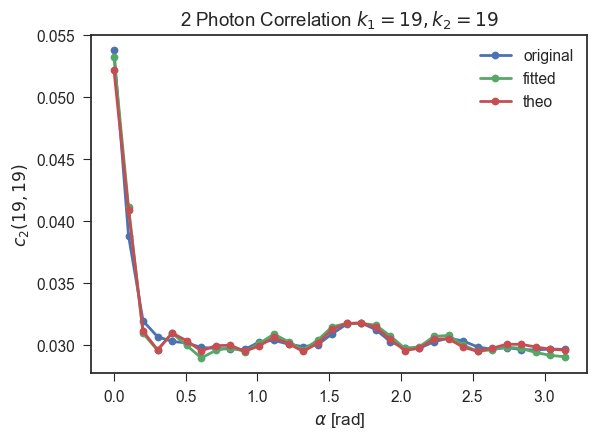

In [430]:
# plot_single_2photon_slice(Dict("original"=>c2_theo_lambda4, "fitted"=>c2_theo_lambda4_exp), 28, 17)
plot_random_2photon_slices(Dict("original"=>orig/sumabs(orig), "fitted"=>fitted/sumabs(fitted), "theo"=>theo/sumabs(theo)))
# plot_random_2photon_slices(Dict("original"=>orig/sumabs(orig), "fitted"=>fitted/sumabs(fitted)))

In [ ]:
creload(ThreePhotons)

In [ ]:
basis = calculate_basis(L, LMAX, N, K, lambda, dq(intensity_K38))
# CUDA_init()
# d_basis = CUDA_store_basis(basis)
println("Done")

In [ ]:
c3_ewald_theo = FullCorrelation_parallized(intensity_K38, basis, true, false, false)
println("done")

Interact.Options{:SelectionSlider,Any}(58: "input-26" = 19 Any ,"k1",19,"19",19,Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict{Any,Any}(Pair{Any,Any}(18,"18"),Pair{Any,Any}(30,"30"),Pair{Any,Any}(33,"33"),Pair{Any,Any}(32,"32"),Pair{Any,Any}(2,"2"),Pair{Any,Any}(16,"16"),Pair{Any,Any}(11,"11"),Pair{Any,Any}(21,"21"),Pair{Any,Any}(7,"7"),Pair{Any,Any}(9,"9")…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Any}(60: "input-27" = 19 Any ,"k2",19,"19",19,Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict{Any,Any}(Pair{Any,Any}(18,"18"),Pair{Any,Any}(30,"30"),Pair{Any,Any}(33,"33"),Pair{Any,Any}(32,"32"),Pair{Any,Any}(2,"2"),Pair{Any,Any}(16,"16"),Pair{Any,Any}(11,"11"),Pair{Any,Any}(21,"21"),Pair{Any,Any}(7,"7"),Pair{Any,Any}(9,"9")…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Any}(62: "input-28" = 19 Any ,"k3",19,"19",19,Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict{Any,Any}(Pair{Any,Any}(18,"18"),Pair{Any,Any}(30,"30"),Pair{Any,Any}(33,"33"),Pair{Any,Any}(32,"32"),Pair{Any,Any}(2,"2"),Pair{Any,Any}(16,"16"),Pair{Any,Any}(11,"11"),Pair{Any,Any}(21,"21"),Pair{Any,Any}(7,"7"),Pair{Any,Any}(9,"9")…)),Any[],Any[],true,"horizontal")

Interact.Checkbox(64: "input-29" = true Bool ,"normalization",true)

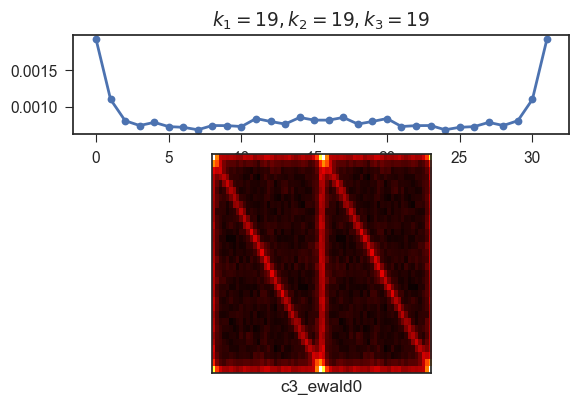

In [61]:
plot_random_3photon_slices(Dict("c3_ewald0"=>c3_ewald0,
#         "ewald_theo"=>c3_ewald_theo
        ))

# Scaling

In [68]:
K = 10
L = 10
num_parameters = (K,L) -> K*(K+1)*(K+2)/6*L^4
num_parameters(2*K,2*L)/num_parameters(K,L)

112.0